[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/efurlanm/418/blob/master/pchip-impl-numpy.ipynb)

# PCHIP Implementation in pure Numpy

*Last edited 2023-05-26*

Based on the work:

Pchip interpolation implementation in pure Numpy  
https://gist.github.com/tito/553f1135959921ce6699652bf656150d

Authors  
Michael Taylor <mtaylor@atlanticsciences.com>  
Mathieu Virbel <mat@meltingrocks.com>

The idea of this Notebook is to compare the implementation of PCHIP in Python and Numpy, made by Taylor-Virbel, with the implementation of the SciPy library. The points to be interpolated are created using Burkardt's Gauss-Hermite Quadrature (GHQ) model that were generated in Notebook pchip-quadrature-burgers.ipynb.

The Taylor-Virbel implementation is shown below. It uses a parameter called "mode" which selects between two algorithms, a default called "mono" which is based on the Fritsch-Carlson algorithm, and another "quad" which is a quadratic polynomial fit.

mode=='mono', Fritsch-Carlson algorithm from fortran numerical recipe  
mode == "quad", quadratic polynomial fit

Fritsch and Carlson (1980), "Monotone Piecewise Cubic Interpolation", SIAM Journal of Numerical Analysis, Vol. 17, No. 2, pp. 238-246. 

In [19]:
from scipy.interpolate import pchip_interpolate as scipy_pchip_interpolate

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
import numpy as np
from numpy import (zeros, where, diff, floor, minimum, maximum, array,
                   concatenate, logical_or, logical_xor)
from numpy.fft import rfft, irfft

In [27]:
def pchip_interpolate(xi, yi, x, mode="mono"):
    """
    Interpolation using piecewise cubic Hermite polynomial.
    """
    if mode not in ("mono", "quad"):
        raise ValueError("Unrecognized mode string")
        
    if mode == "quad":
        print("quad")
    else:
        print("mono")

    # Search for [xi,xi+1] interval for each x
    xi = xi.astype("double")
    yi = yi.astype("double")

    x_index = zeros(len(x), dtype="int")
    xi_steps = diff(xi)
    if not all(xi_steps > 0):
        raise ValueError("x-coordinates are not in increasing order.")

    x_steps = diff(x)
    if xi_steps.max() / xi_steps.min() < 1.000001:
        # uniform input grid
        if __debug__:
            print("pchip: uniform input grid")
        xi_start = xi[0]
        xi_step = (xi[-1] - xi[0]) / (len(xi) - 1)
        x_index = minimum(
            maximum(floor((x - xi_start) / xi_step).astype(int), 0),
            len(xi) - 2)

        # Calculate gradients d
        h = (xi[-1] - xi[0]) / (len(xi) - 1)
        d = zeros(len(xi), dtype="double")
        if mode == "quad":
            # quadratic polynomial fit
            d[[0]] = (yi[1] - yi[0]) / h
            d[[-1]] = (yi[-1] - yi[-2]) / h
            d[1:-1] = (yi[2:] - yi[0:-2]) / 2 / h
        else:
            # mode=='mono', Fritsch-Carlson algorithm from fortran numerical
            # recipe
            delta = diff(yi) / h
            d = concatenate(
                (delta[0:1], 2 / (1 / delta[0:-1] + 1 / delta[1:]), delta[-1:]))
            d[concatenate(
                (array([False]), logical_xor(delta[0:-1] > 0, delta[1:]
                                             > 0), array([False])))] = 0
            d[logical_or(concatenate((array([False]), delta == 0)),
                         concatenate((delta == 0, array([False]))))] = 0
        # Calculate output values y
        dxxi = x - xi[x_index]
        dxxid = x - xi[1 + x_index]
        dxxi2 = pow(dxxi, 2)
        dxxid2 = pow(dxxid, 2)
        y = (2 / pow(h, 3) *
             (yi[x_index] * dxxid2 * (dxxi + h / 2) - yi[1 + x_index] * dxxi2 *
              (dxxid - h / 2)) + 1 / pow(h, 2) *
             (d[x_index] * dxxid2 * dxxi + d[1 + x_index] * dxxi2 * dxxid))
    else:
        # not uniform input grid
        if (x_steps.max() / x_steps.min() < 1.000001 and
                x_steps.max() / x_steps.min() > 0.999999):
            # non-uniform input grid, uniform output grid
            if __debug__:
                print("pchip: non-uniform input grid, uniform output grid")
            x_decreasing = x[-1] < x[0]
            if x_decreasing:
                x = x[::-1]
            x_start = x[0]
            x_step = (x[-1] - x[0]) / (len(x) - 1)
            x_indexprev = -1
            for xi_loop in range(len(xi) - 2):
                x_indexcur = max(
                    int(floor((xi[1 + xi_loop] - x_start) / x_step)), -1)
                x_index[1 + x_indexprev:1 + x_indexcur] = xi_loop
                x_indexprev = x_indexcur
            x_index[1 + x_indexprev:] = len(xi) - 2
            if x_decreasing:
                x = x[::-1]
                x_index = x_index[::-1]
        elif all(x_steps > 0) or all(x_steps < 0):
            # non-uniform input/output grids, output grid monotonic
            if __debug__:
                print("pchip: non-uniform in/out grid, output grid monotonic")
            x_decreasing = x[-1] < x[0]
            if x_decreasing:
                x = x[::-1]
            x_len = len(x)
            x_loop = 0
            for xi_loop in range(len(xi) - 1):
                while x_loop < x_len and x[x_loop] < xi[1 + xi_loop]:
                    x_index[x_loop] = xi_loop
                    x_loop += 1
            x_index[x_loop:] = len(xi) - 2
            if x_decreasing:
                x = x[::-1]
                x_index = x_index[::-1]
        else:
            # non-uniform input/output grids, output grid not monotonic
            if __debug__:
                print("pchip: non-uniform in/out grids, "
                      "output grid not monotonic")
            for index in range(len(x)):
                loc = where(x[index] < xi)[0]
                if loc.size == 0:
                    x_index[index] = len(xi) - 2
                elif loc[0] == 0:
                    x_index[index] = 0
                else:
                    x_index[index] = loc[0] - 1
        # Calculate gradients d
        h = diff(xi)
        d = zeros(len(xi), dtype="double")
        delta = diff(yi) / h
        if mode == "quad":
            # quadratic polynomial fit
            d[[0, -1]] = delta[[0, -1]]
            d[1:-1] = (delta[1:] * h[0:-1] + delta[0:-1] * h[1:]) / (h[0:-1] +
                                                                     h[1:])
        else:
            # mode=='mono', Fritsch-Carlson algorithm from fortran numerical
            # recipe
            d = concatenate((delta[0:1], 3 * (h[0:-1] + h[1:]) /
                             ((h[0:-1] + 2 * h[1:]) / delta[0:-1] +
                              (2 * h[0:-1] + h[1:]) / delta[1:]), delta[-1:]))
            d[concatenate(
                (array([False]), logical_xor(delta[0:-1] > 0, delta[1:]
                                             > 0), array([False])))] = 0
            d[logical_or(concatenate((array([False]), delta == 0)),
                         concatenate((delta == 0, array([False]))))] = 0
        dxxi = x - xi[x_index]
        dxxid = x - xi[1 + x_index]
        dxxi2 = pow(dxxi, 2)
        dxxid2 = pow(dxxid, 2)
        y = (2 / pow(h[x_index], 3) *
             (yi[x_index] * dxxid2 *
              (dxxi + h[x_index] / 2) - yi[1 + x_index] * dxxi2 *
              (dxxid - h[x_index] / 2)) + 1 / pow(h[x_index], 2) *
             (d[x_index] * dxxid2 * dxxi + d[1 + x_index] * dxxi2 * dxxid))
    return y

# Generation of input data

The following code generates 10 points that will be used as input for the PCHIP interpolator.

In [28]:
vtn = 10  # NT : Time t
vxn = 10  # NX : Variable x

xlo = -1.0
xhi = +1.0
vx = np.linspace(xlo, xhi, vxn)

tlo = 0.0
thi = 0.99
vt = np.linspace(tlo, thi, vtn)

Loads Burkardt's Gauss-Hermite Quadrature (GHQ) model data that was generated in Notebook pchip-quadrature-burgers.ipynb.:

In [6]:
vx = np.loadtxt('burgers_solution_x.csv', delimiter=",")
vt = np.loadtxt('burgers_solution_t.csv', delimiter=",")
vu = np.loadtxt('burgers_solution_u.csv', delimiter=",")

Result using Taylor-Virbel, for two instants of time, and using the "mono" and "quad" models:

In [29]:
x_observed = vx
y_observed = vu[2, :]
xq = np.linspace(min(x_observed), max(x_observed), num=100)
yq = pchip_interpolate(x_observed, y_observed, xq)

mono
pchip: uniform input grid


In [30]:
x_observed2 = vx
y_observed2 = vu[7, :]
xq2 = np.linspace(min(x_observed2), max(x_observed2), num=100)
yq2 = pchip_interpolate(x_observed2, y_observed2, xq)

mono
pchip: uniform input grid


In [31]:
yq3 = pchip_interpolate(x_observed, y_observed, xq, mode="quad")

quad
pchip: uniform input grid


In [32]:
yq4 = pchip_interpolate(x_observed2, y_observed2, xq, mode="quad")

quad
pchip: uniform input grid


Result using SciPy implementation:

In [23]:
yq5 = scipy_pchip_interpolate(x_observed, y_observed, xq)

In [24]:
yq6 = scipy_pchip_interpolate(x_observed2, y_observed2, xq)

The superimposed curves below make a comparison between models. The yellow (mono) and red (scipy) curves are practically coincident, showing that the implementations are equivalent. However, the green curve (quad) shows a certain deviation, especially at the sharp edges:

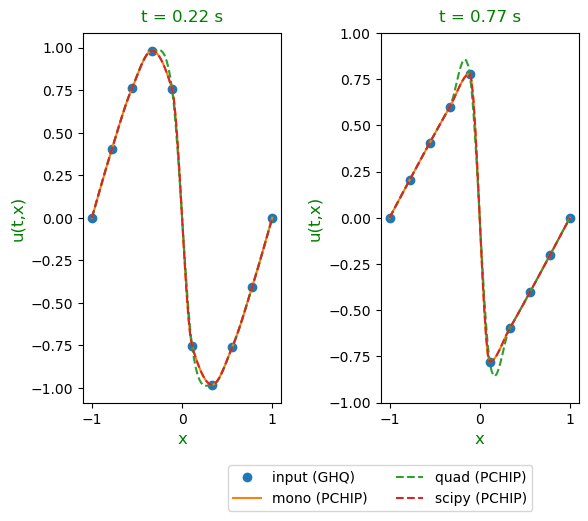

In [33]:
font = {'size': 'large', 'color': 'green'}
gs = gridspec.GridSpec(1, 2, wspace=.5)

ax = plt.subplot(gs[0, 0])
ax.plot(vx, vu[2, :], "o", label="input (GHQ)")
ax.plot(xq, yq, label="mono (PCHIP)")
ax.plot(xq, yq3, "--", label="quad (PCHIP)")
ax.plot(xq, yq5, "--", label="scipy (PCHIP)")
ax.set_title(f"t = {vt[2]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)

ax = plt.subplot(gs[0, 1])
plt.plot(vx, vu[7, :], "o", label="input (GHQ)")
ax.plot(xq2, yq2, label="mono (PCHIP)")
plt.plot(xq2, yq4, "--", label="quad (PCHIP)")
plt.plot(xq2, yq6, "--", label="scipy (PCHIP)")
ax.set_title(f"t = {vt[7]} s", verticalalignment='bottom', **font)
ax.set_xlabel('x', **font)
ax.set_ylabel('u(t,x)', **font)
ax.set_ylim([-1, 1])

ax.legend(bbox_to_anchor=(0.8, -0.15), ncol=2)
plt.show()

# Conclusion

This work sought to compare a Python implementation of the PCHIP model with the SciPy (scipy) implementation. The model in Python has two algorithms, the mono (Fritsch-Carlson) and the quad (quadratic polynomial fit). The results showed that mono and scipy are very close, while quad has deviation mainly in sharp corners of the curves.

# References

[1] ROBERTS, T. W. [Non-oscillatory interpolation for the Semi-Lagrangian scheme](https://www.reading.ac.uk/maths-and-stats/-/media/project/uor-main/schools-departments/maths/documents/tomos-roberts.pdf). 2009.

[2] BASDEVANT, C.; et al. Spectral and finite difference solutions of the Burgers equation. Computers & fluids 14 (1986) 23–41.

[3] RAISSI, M.; et al. Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations. 2017. DOI 10.48550/arXiv.1711.10561

[4] Fritsch, F. N., & Carlson, R. E. (1980). Monotone Piecewise Cubic Interpolation. SIAM Journal on Numerical Analysis, 17(2), Article 2.

[5] Kahaner, D., Moler, C. B., & Nash, S. (1988). Numerical Methods and Software. Prentice Hall.